In [1]:
import praw
import prawcore
from time import sleep
from tqdm.notebook import tqdm
import json
import pandas as pd
from datetime import datetime
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
# !pip install langdetect
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException
# !pip install wordcloud
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from itertools import chain
import seaborn as sns
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.lda_model
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import string
from tabulate import tabulate
import networkx as nx
from networkx.algorithms.community import label_propagation_communities
import community.community_louvain as community_louvain
import random

# Suppress specific warning categories
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv("..\\Processing\\reddit_russiaukraine_cleaned.csv")


In [3]:
#drop null from cleaned_string
df = df[df['cleaned_string'].notnull()]

In [4]:
#total null values
df.isnull().sum()

id                     0
type                   0
subreddit              0
title              34483
selftext           36189
created_utc            0
created                0
author               861
score                  0
upvote_ratio       34483
num_comments       34483
url                34483
permalink              0
parent_id           1944
link_id             1944
body                1944
text                   0
tokens                 0
tokens_filtered        0
final_tokens           0
cleaned_string         0
dtype: int64

In [5]:
comments_df = df[(df['type'] == 'comment') & (df['parent_id'].str.startswith('t1_'))]
id_to_author = df.set_index("id")["author"].to_dict()

In [6]:
G = nx.DiGraph()

for _, row in comments_df.iterrows():
    parent_id = row['parent_id'].split('_')[1]
    source = row['author']
    target = id_to_author.get(parent_id)

    if source not in ['[deleted]', None] and target not in ['[deleted]', None] and source != target:
        G.add_edge(source, target)


In [7]:
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
avg_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Average Degree: {avg_degree:.2f}")

Nodes: 5705
Edges: 14417
Average Degree: 5.05


In [8]:
deg_cent = nx.degree_centrality(G)
top_users = sorted(deg_cent.items(), key=lambda x: x[1], reverse=True)[:10]
print("\nTop 10 Users by Degree Centrality:")
for user, score in top_users:
    print(f"{user}: {score:.4f}")


Top 10 Users by Degree Centrality:
nan: 0.0885
Different-Shelter-96: 0.0431
eldenpotato: 0.0337
ForowellDEATh: 0.0335
FruitSila: 0.0295
HostileFleetEvading: 0.0291
Jimieus: 0.0289
Fit_Rice_3485: 0.0277
Mapstr_: 0.0238
Pryamus: 0.0237


In [9]:
# nx.write_graphml(G, "reddit_user_interaction.graphml")
# print("\nGraph saved as 'reddit_user_interaction.graphml'")

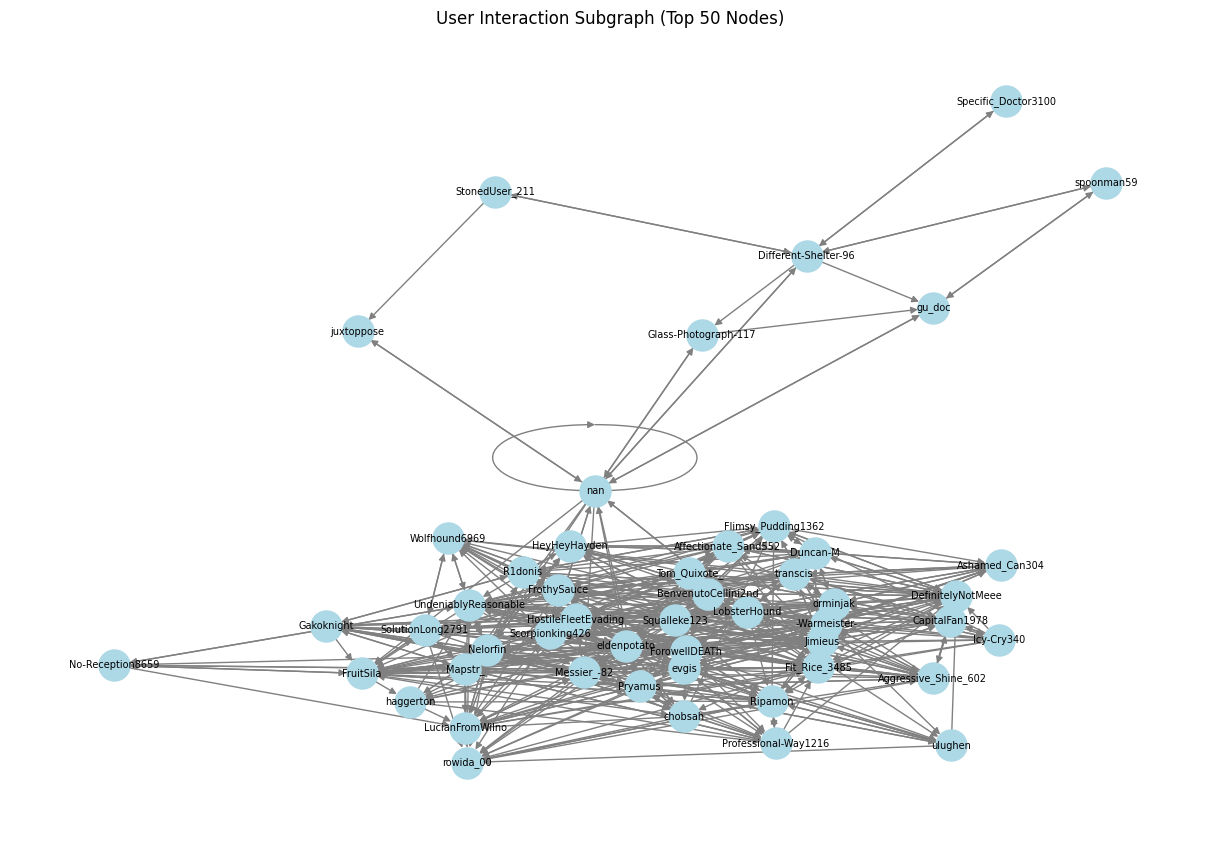

In [10]:
# Read back the GraphML file
replyGraph = nx.read_graphml("reddit_user_interaction.graphml")

# Get top 100 nodes by degree
top_nodes = sorted(replyGraph.degree, key=lambda x: x[1], reverse=True)[:50]
top_node_ids = [node for node, _ in top_nodes]
subgraph = replyGraph.subgraph(top_node_ids)

# Draw the subgraph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=7, edge_color='gray')

# Optional: Add Katz centrality or degree as labels (if computed)
# labels = {n: f"{n}" for n in subgraph.nodes()}
# nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=6)

plt.title("User Interaction Subgraph (Top 50 Nodes)")
plt.tight_layout()
plt.show()

In [11]:
top_post = df[(df['type'] == 'submission')].sort_values(by='score', ascending=False).iloc[0]
top_post_id = top_post['id']


In [12]:
top_comments_df = df[(df['type'] == 'comment') & (df['link_id'] == f"t3_{top_post_id}")]


In [13]:
top_comments = top_comments_df.sort_values(by='score', ascending=False).head(100)
top_comment_ids = top_comments['id'].tolist()


In [14]:
G_top_comments = nx.DiGraph()

# Create lookup map
id_to_author = df.set_index('id')['author'].to_dict()

for _, row in top_comments.iterrows():
    if str(row['parent_id']).startswith("t1_"):
        parent_id = row['parent_id'].split('_')[1]
        source = row['author']
        target = id_to_author.get(parent_id)

        if source and target and source != '[deleted]' and target != '[deleted]' and source != target:
            G_top_comments.add_edge(source, target)


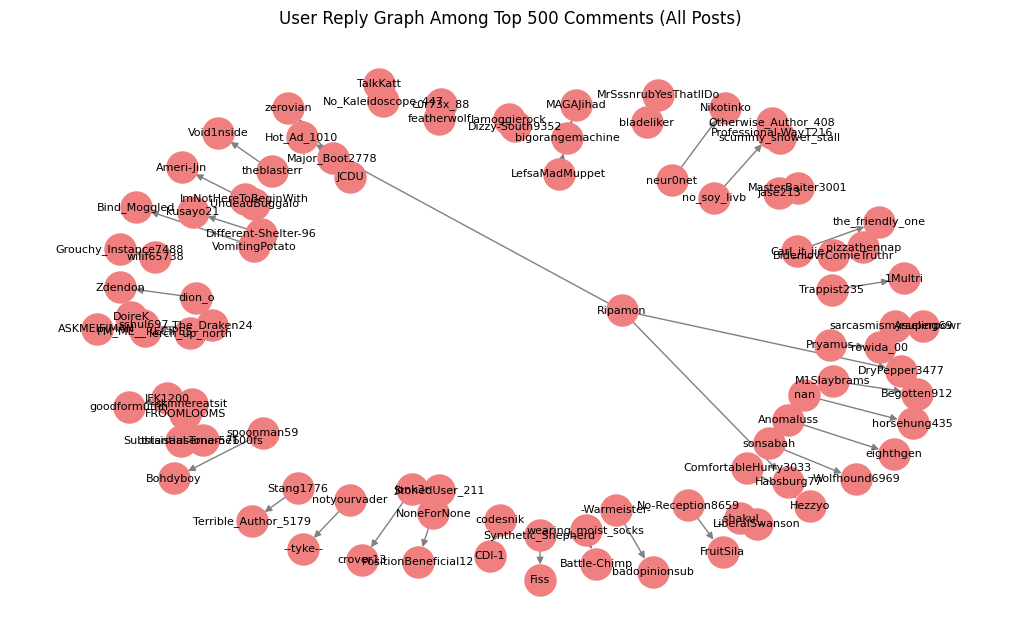

In [15]:
top_comments = df[(df['type'] == 'comment')].sort_values(by='score', ascending=False).head(500)
top_comment_ids = top_comments['id'].tolist()

# Now find reply edges among these top comments
G_top = nx.DiGraph()
id_to_author = df.set_index('id')['author'].to_dict()

for _, row in top_comments.iterrows():
    if str(row['parent_id']).startswith('t1_'):
        parent_id = row['parent_id'].split('_')[1]
        source = row['author']
        target = id_to_author.get(parent_id)
        
        if source and target and source != '[deleted]' and target != '[deleted]' and source != target:
            G_top.add_edge(source, target)

# Visualize if graph is not empty
if G_top.number_of_edges() > 0:
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(G_top, seed=42)
    nx.draw(G_top, pos, with_labels=True, node_color='lightcoral', edge_color='gray', node_size=500, font_size=8)
    plt.title("User Reply Graph Among Top 500 Comments (All Posts)")
    plt.tight_layout()
    plt.show()
else:
    print("No interactions found among top 100 comments globally either.")


In [16]:
comments_df = df[(df['type'] == 'comment') & (df['parent_id'].str.startswith('t1_'))]
id_to_author = df.set_index("id")["author"].to_dict()

G_full = nx.DiGraph()
for _, row in comments_df.iterrows():
    parent_id = row['parent_id'].split('_')[1]
    source = row['author']
    target = id_to_author.get(parent_id)
    if source and target and source != '[deleted]' and target != '[deleted]' and source != target:
        G_full.add_edge(source, target)

print(f"Graph 1: Full Graph → Nodes: {G_full.number_of_nodes()}, Edges: {G_full.number_of_edges()}")


Graph 1: Full Graph → Nodes: 5705, Edges: 14417


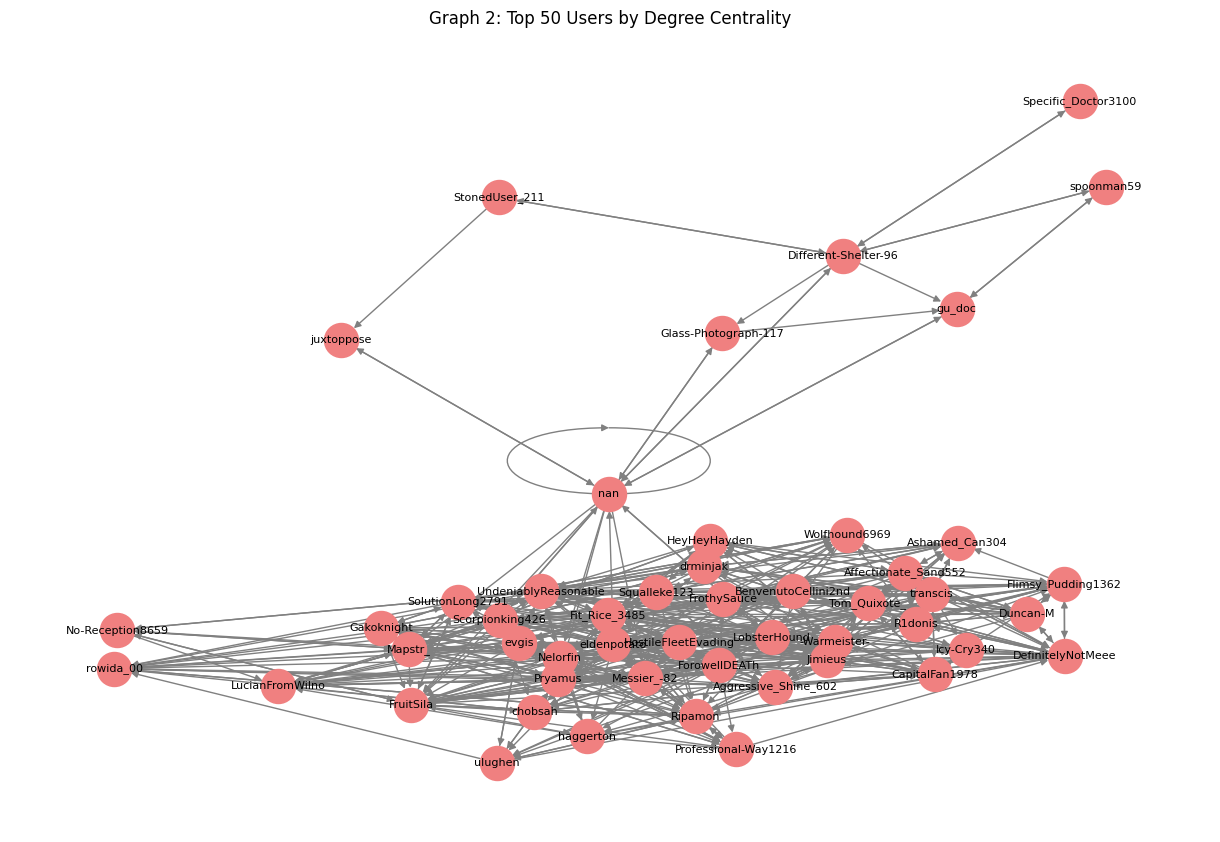

In [17]:
top50_nodes = sorted(G_full.degree, key=lambda x: x[1], reverse=True)[:50]
top50_ids = [n for n, _ in top50_nodes]
G_top50 = G_full.subgraph(top50_ids)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_top50, seed=42)
nx.draw(G_top50, pos, with_labels=True, node_color='lightcoral', node_size=600, edge_color='gray', font_size=8)
plt.title("Graph 2: Top 50 Users by Degree Centrality")
plt.tight_layout()
plt.savefig("graph2_top50_users.png")
plt.show()

In [18]:
metrics_full = {
    'In-Degree': dict(G_full.in_degree()),
    'Out-Degree': dict(G_full.out_degree()),
    'Degree Centrality': nx.degree_centrality(G_full),
    'Eigenvector Centrality': nx.eigenvector_centrality(G_full, max_iter=1000),
    'Closeness Centrality': nx.closeness_centrality(G_full),
}
df_full = pd.DataFrame(metrics_full)
summary_full = df_full.describe().rename(index={
    "count": "Count", "mean": "Mean", "std": "Std. Dev", "min": "Min",
    "25%": "25th Percentile", "50%": "50th Percentile",
    "75%": "75th Percentile", "max": "Max"
})

In [19]:
metrics_top50 = {
    'In-Degree': dict(G_top50.in_degree()),
    'Out-Degree': dict(G_top50.out_degree()),
    'Degree Centrality': nx.degree_centrality(G_top50),
    'Eigenvector Centrality': nx.eigenvector_centrality(G_top50, max_iter=1000),
    'Closeness Centrality': nx.closeness_centrality(G_top50),
}
df_top50 = pd.DataFrame(metrics_top50)
summary_top50 = df_top50.describe().rename(index={
    "count": "Count", "mean": "Mean", "std": "Std. Dev", "min": "Min",
    "25%": "25th Percentile", "50%": "50th Percentile",
    "75%": "75th Percentile", "max": "Max"
})

In [20]:
print("\n=== Summary: Full Graph ===")
print(tabulate(summary_full, headers='keys', tablefmt='grid', floatfmt=".4f"))


=== Summary: Full Graph ===
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
|                 |   In-Degree |   Out-Degree |   Degree Centrality |   Eigenvector Centrality |   Closeness Centrality |
+=================+=============+==============+=====================+==========================+========================+
| Count           |   5705.0000 |    5705.0000 |           5705.0000 |                5705.0000 |              5705.0000 |
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
| Mean            |      2.5271 |       2.5271 |              0.0009 |                   0.0031 |                 0.0717 |
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
| Std. Dev        |      7.0410 |       6.6348 |              0.0023 |                   0.0129 |             

In [21]:
print("\n=== Summary: Top 50 Users Subgraph ===")
print(tabulate(summary_top50, headers='keys', tablefmt='grid', floatfmt=".4f"))


=== Summary: Top 50 Users Subgraph ===
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
|                 |   In-Degree |   Out-Degree |   Degree Centrality |   Eigenvector Centrality |   Closeness Centrality |
+=================+=============+==============+=====================+==========================+========================+
| Count           |     50.0000 |      50.0000 |             50.0000 |                  50.0000 |                50.0000 |
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
| Mean            |     11.0200 |      11.0200 |              0.4498 |                   0.1199 |                 0.4795 |
+-----------------+-------------+--------------+---------------------+--------------------------+------------------------+
| Std. Dev        |      6.1727 |       6.1095 |              0.2214 |                   0.0758 |  

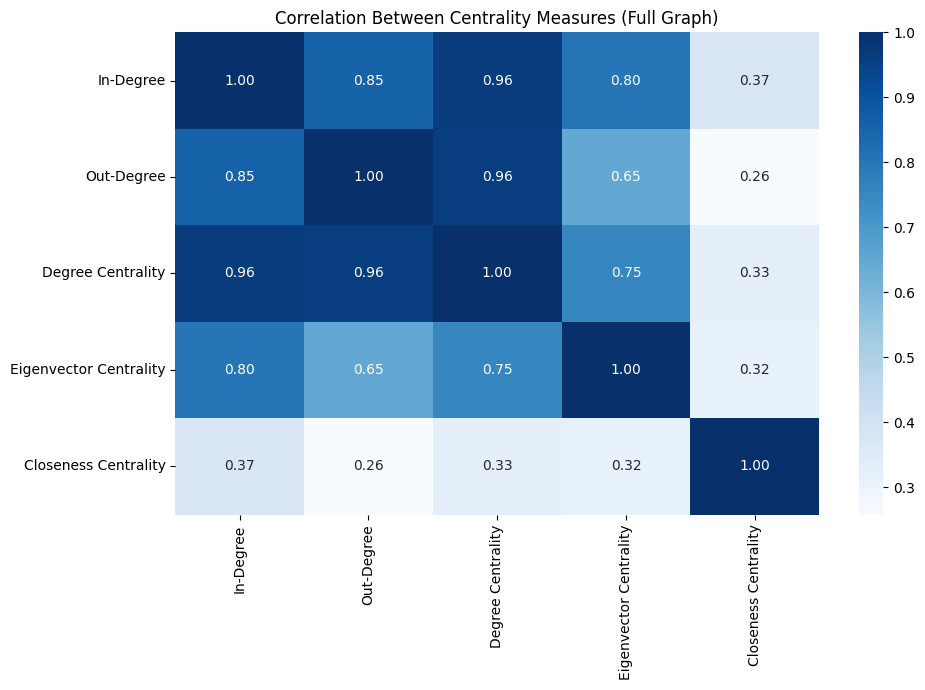

In [22]:
# Correlation heatmap for full graph
plt.figure(figsize=(10, 7))
corr = df_full.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Blues")
plt.title("Correlation Between Centrality Measures (Full Graph)")
plt.tight_layout()
plt.savefig("centrality_correlation_full.png")
plt.show()

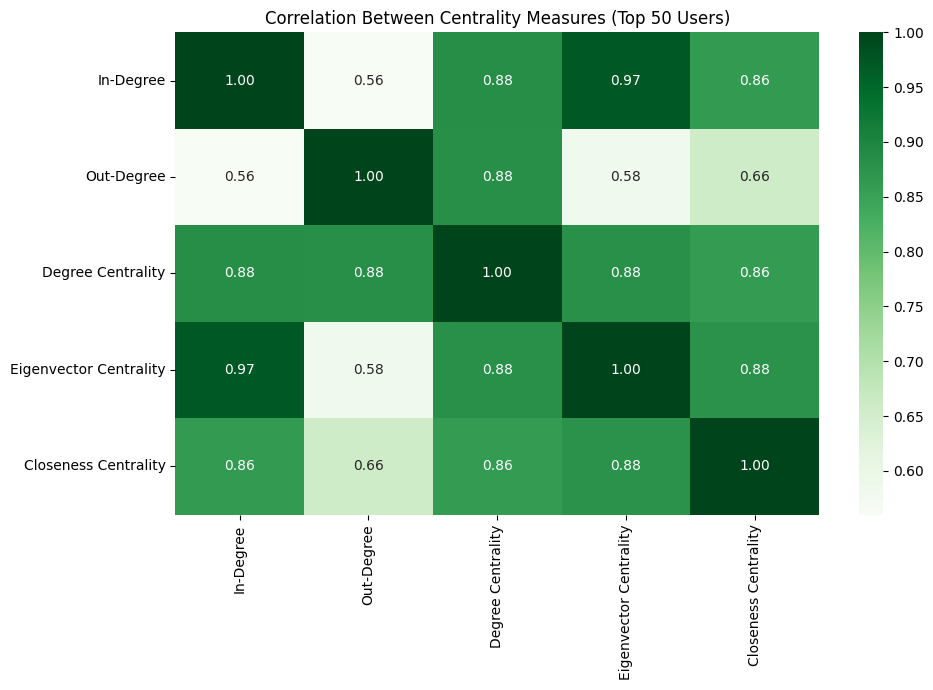

In [23]:
plt.figure(figsize=(10, 7))
corr_top50 = df_top50.corr()
sns.heatmap(corr_top50, annot=True, fmt=".2f", cmap="Greens")
plt.title("Correlation Between Centrality Measures (Top 50 Users)")
plt.tight_layout()
plt.savefig("centrality_correlation_top50.png")
plt.show()


In [24]:
partition_louvain = community_louvain.best_partition(G_full.to_undirected())
nx.set_node_attributes(G_full, partition_louvain, 'community_louvain')

# Label Propagation (built-in method)
label_prop_gen = label_propagation_communities(G_full.to_undirected())
partition_label = {}
for i, community in enumerate(label_prop_gen):
    for node in community:
        partition_label[node] = i
nx.set_node_attributes(G_full, partition_label, 'community_labelprop')

In [25]:
print(f"Louvain communities: {len(set(partition_louvain.values()))}")
print(f"Label Propagation communities: {len(set(partition_label.values()))}")


Louvain communities: 232
Label Propagation communities: 1178


In [26]:
# Visualize communities on top-50 subgraph
colors_louvain = [partition_louvain.get(node, -1) for node in G_top50.nodes()]
colors_label = [partition_label.get(node, -1) for node in G_top50.nodes()]


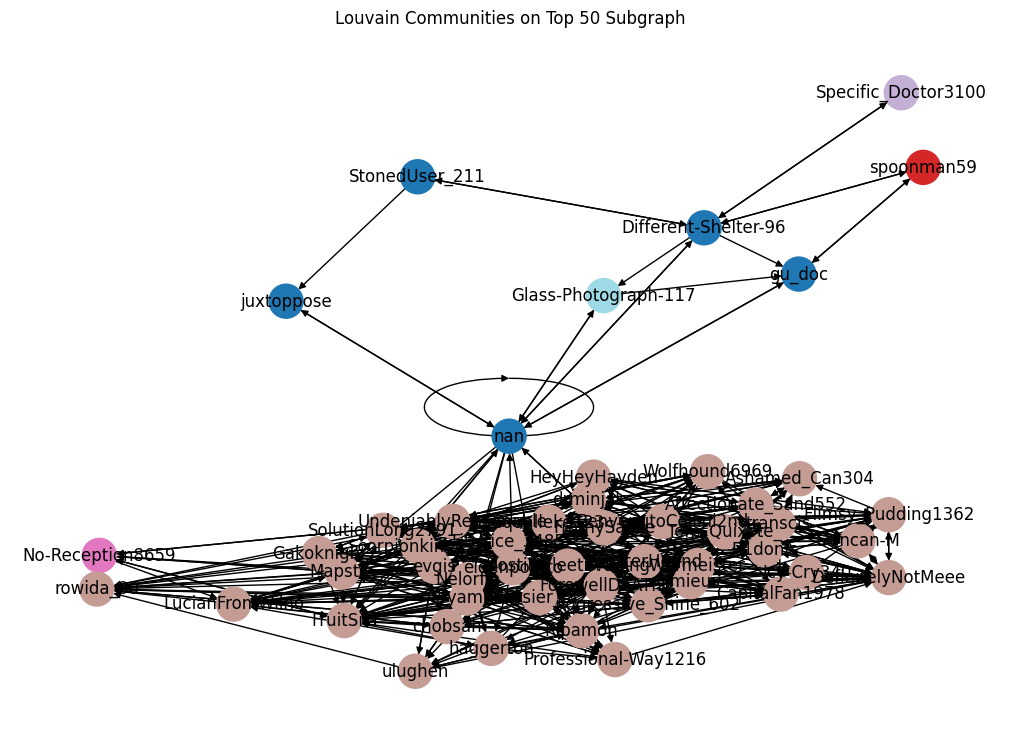

In [27]:
plt.figure(figsize=(10, 7))
pos = nx.spring_layout(G_top50, seed=42)
nx.draw(G_top50, pos, node_color=colors_louvain, with_labels=True, cmap='tab20', node_size=600)
plt.title("Louvain Communities on Top 50 Subgraph")
plt.tight_layout()
plt.savefig("top50_louvain_communities.png")
plt.show()

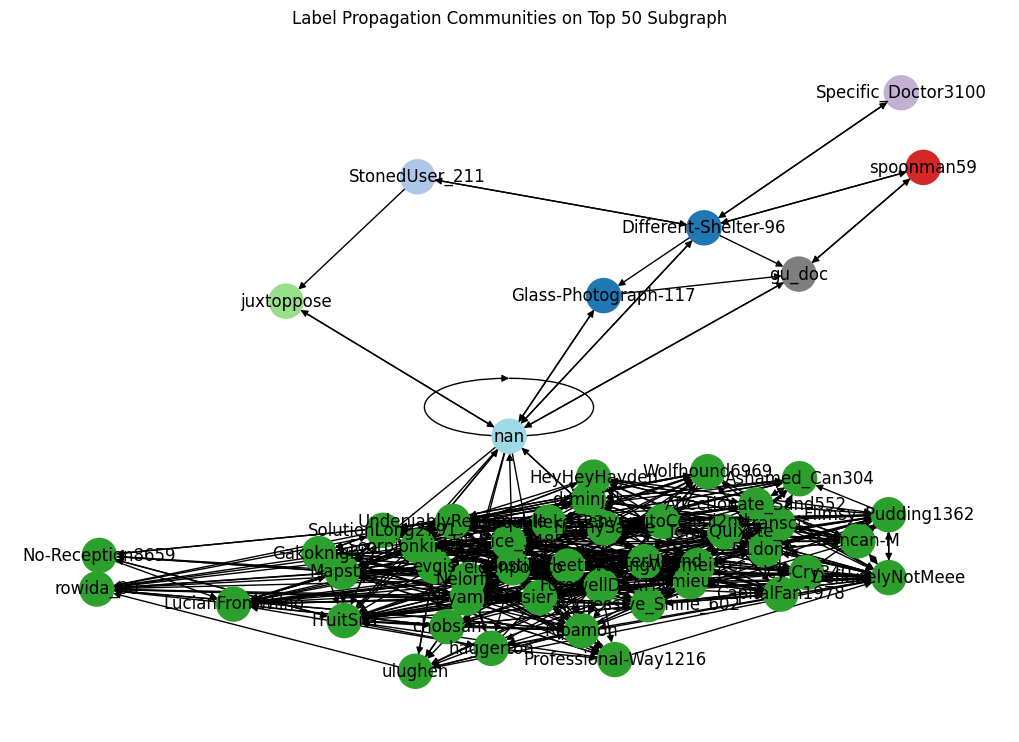

In [28]:
plt.figure(figsize=(10, 7))
nx.draw(G_top50, pos, node_color=colors_label, with_labels=True, cmap='tab20', node_size=600)
plt.title("Label Propagation Communities on Top 50 Subgraph")
plt.tight_layout()
plt.savefig("top50_labelprop_communities.png")
plt.show()


In [29]:
# Compare modularity scores
mod_louvain = community_louvain.modularity(partition_louvain, G_full.to_undirected())
mod_labelprop = nx.algorithms.community.quality.modularity(G_full.to_undirected(), [
    [n for n, cid in partition_label.items() if cid == c] for c in set(partition_label.values())
])

In [30]:

print(f"Louvain Modularity Score: {mod_louvain:.4f}")
print(f"Label Propagation Modularity Score: {mod_labelprop:.4f}")

Louvain Modularity Score: 0.5733
Label Propagation Modularity Score: 0.4578


In [31]:
# Sample subgraph from full graph (top 500 by degree)
top500_nodes = sorted(G_full.degree, key=lambda x: x[1], reverse=True)[:500]
top500_ids = [n for n, _ in top500_nodes]
G_top500 = G_full.subgraph(top500_ids).copy()

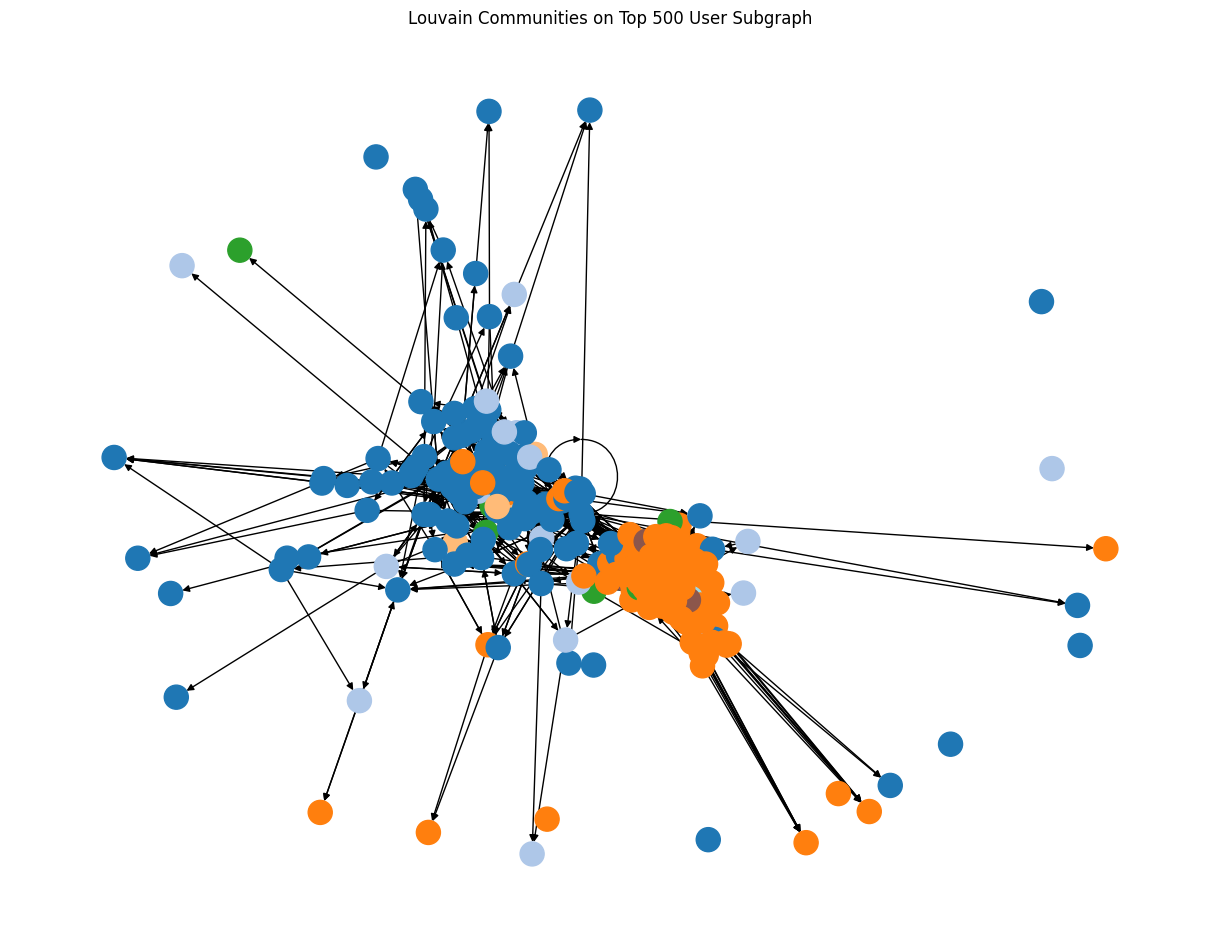

In [32]:
plt.figure(figsize=(12, 9))
pos_500 = nx.spring_layout(G_top500, seed=42)
colors_500_louvain = [partition_louvain.get(n, -1) for n in G_top500.nodes()]
nx.draw(G_top500, pos_500, node_color=colors_500_louvain, cmap="tab20", node_size=300, with_labels=False)
plt.title("Louvain Communities on Top 500 User Subgraph")
plt.tight_layout()
plt.savefig("top500_louvain_communities.png")
plt.show()

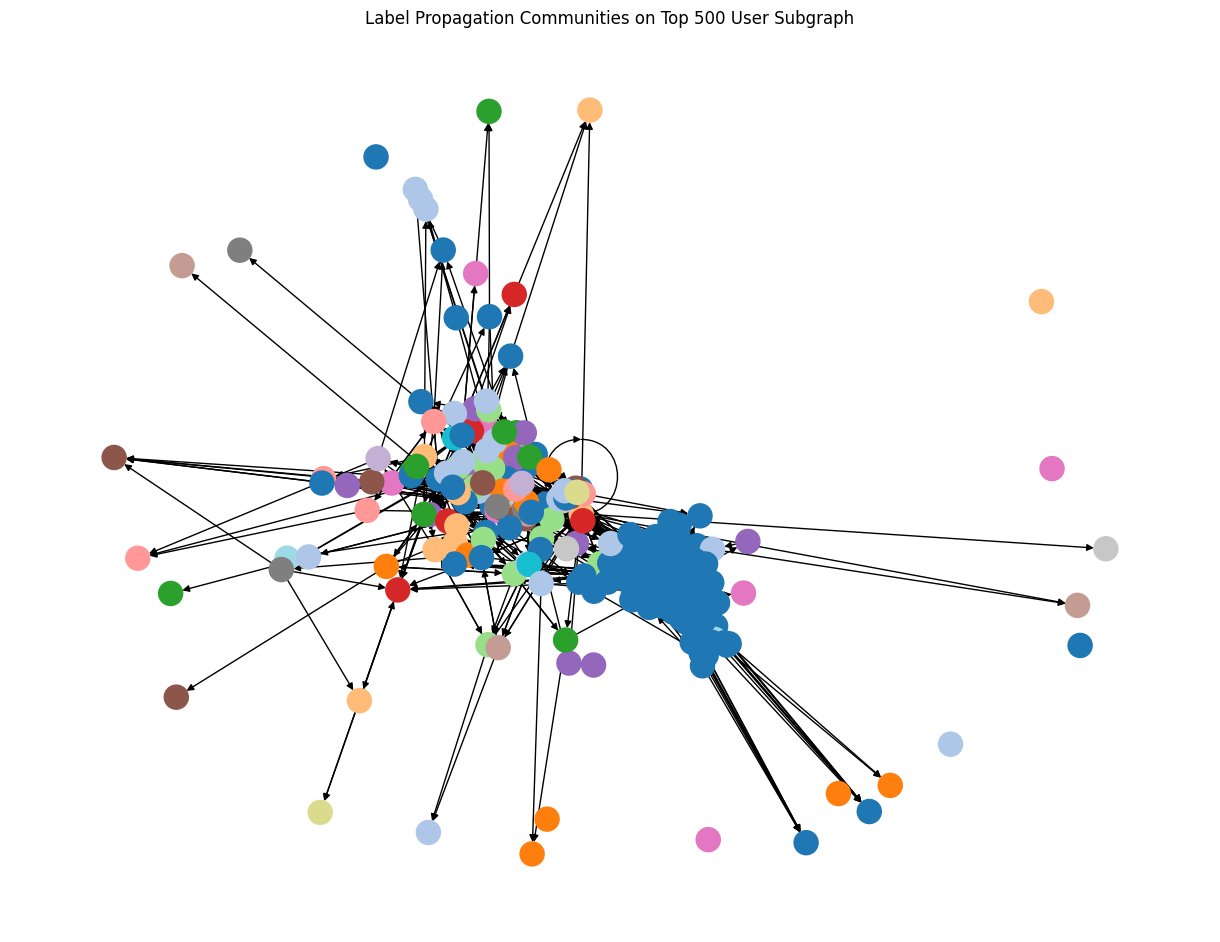

In [33]:
plt.figure(figsize=(12, 9))
colors_500_label = [partition_label.get(n, -1) for n in G_top500.nodes()]
nx.draw(G_top500, pos_500, node_color=colors_500_label, cmap="tab20", node_size=300, with_labels=False)
plt.title("Label Propagation Communities on Top 500 User Subgraph")
plt.tight_layout()
plt.savefig("top200_labelprop_communities.png")
plt.show()

In [34]:
# Compute and print modularity scores for top 500
mod_louvain_500 = community_louvain.modularity({n: partition_louvain[n] for n in G_top500.nodes()}, G_top500.to_undirected())
mod_labelprop_500 = nx.algorithms.community.quality.modularity(
    G_top500.to_undirected(),
    [[n for n in G_top500.nodes() if partition_label[n] == cid] for cid in set(partition_label[n] for n in G_top500.nodes())]
)

In [35]:
print(f"Louvain Modularity Score (Top 500): {mod_louvain_500:.4f}")
print(f"Label Propagation Modularity Score (Top 500): {mod_labelprop_500:.4f}")


Louvain Modularity Score (Top 500): 0.1435
Label Propagation Modularity Score (Top 500): 0.0878


In [36]:
def run_independent_cascade(G, seed_node, p=0.05, max_steps=10):
    UG = G.to_undirected()
    active = set([seed_node])
    newly_active = set([seed_node])
    cascade_edges = []
    steps = [1]

    cascade_graph = nx.DiGraph()
    cascade_graph.add_node(seed_node)

    for _ in range(max_steps):
        next_newly_active = set()
        for node in newly_active:
            for neighbor in UG.neighbors(node):
                if neighbor not in active and random.random() <= p:
                    next_newly_active.add(neighbor)
                    cascade_edges.append((node, neighbor))
        if not next_newly_active:
            break
        newly_active = next_newly_active
        active.update(newly_active)
        steps.append(len(active))

    cascade_graph.add_edges_from(cascade_edges)
    return steps, cascade_graph

In [37]:
valid_nodes = [n for n in G_full.nodes() if str(n).strip().lower() not in ['nan', '[deleted]', 'none']]
random_node = random.choice(valid_nodes)
high_degree_node = max(valid_nodes, key=lambda n: G_full.degree(n))
high_central_node = max(valid_nodes, key=lambda n: nx.degree_centrality(G_full).get(n, 0))


In [38]:
print("Seed Users:")
print("Random:", random_node)
print("High Degree:", high_degree_node)
print("High Centrality:", high_central_node)


Seed Users:
Random: love2kick
High Degree: Different-Shelter-96
High Centrality: Different-Shelter-96


In [39]:
strategies = {
    'Random': random_node,
    'High Degree': high_degree_node,
    'High Centrality': high_central_node
}

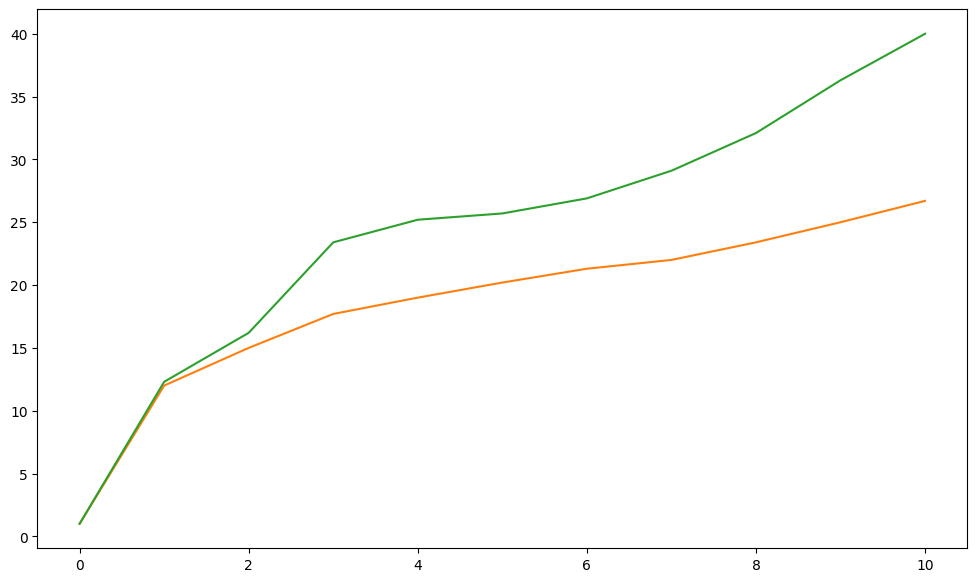

In [40]:
plt.figure(figsize=(12, 7))
for label, seed in strategies.items():
    all_steps = []
    for _ in range(10):
        try:
            steps, _ = run_independent_cascade(G_full, seed, p=0.05, max_steps=10)
            all_steps.append(steps)
        except Exception as e:
            print(f"Error for {label} seed {seed}: {e}")
            continue
    if not all_steps:
        continue
    max_len = max(len(run) for run in all_steps)
    padded_runs = [run + [run[-1]] * (max_len - len(run)) for run in all_steps]
    avg_run = [sum(col) / len(col) for col in zip(*padded_runs)]
    plt.plot(avg_run, label=label)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


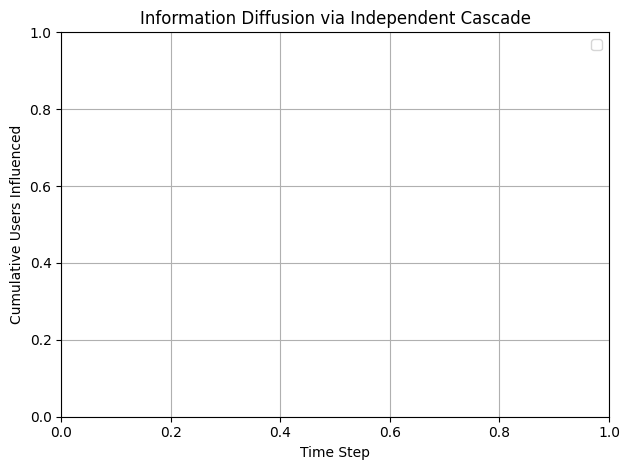

In [41]:
plt.title("Information Diffusion via Independent Cascade")
plt.xlabel("Time Step")
plt.ylabel("Cumulative Users Influenced")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("ic_diffusion_comparison.png")
plt.show()

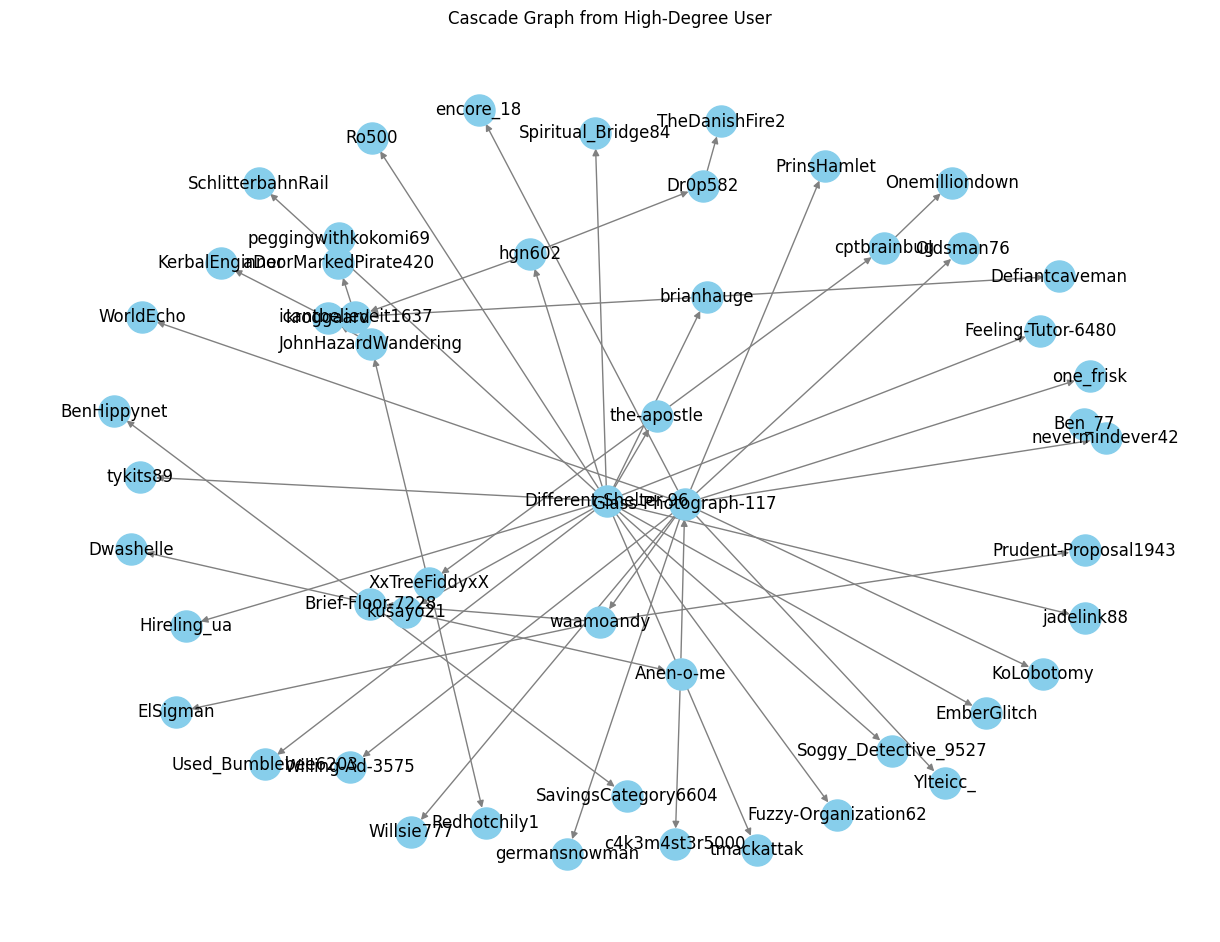

In [42]:
# graph from High-Centrality User
steps, cascade_g = run_independent_cascade(G_full, high_degree_node, p=0.1, max_steps=10)

if isinstance(cascade_g, nx.Graph) and cascade_g.number_of_nodes() > 0:
    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(cascade_g, seed=42)
    nx.draw(cascade_g, pos, with_labels=True, node_size=500, node_color='skyblue', edge_color='gray', arrows=True)
    plt.title("Cascade Graph from High-Degree User")
    plt.tight_layout()
    plt.savefig("cascade_graph_high_degree.png")
    plt.show()
else:
    print("Cascade graph is empty — no further spread from this seed.")


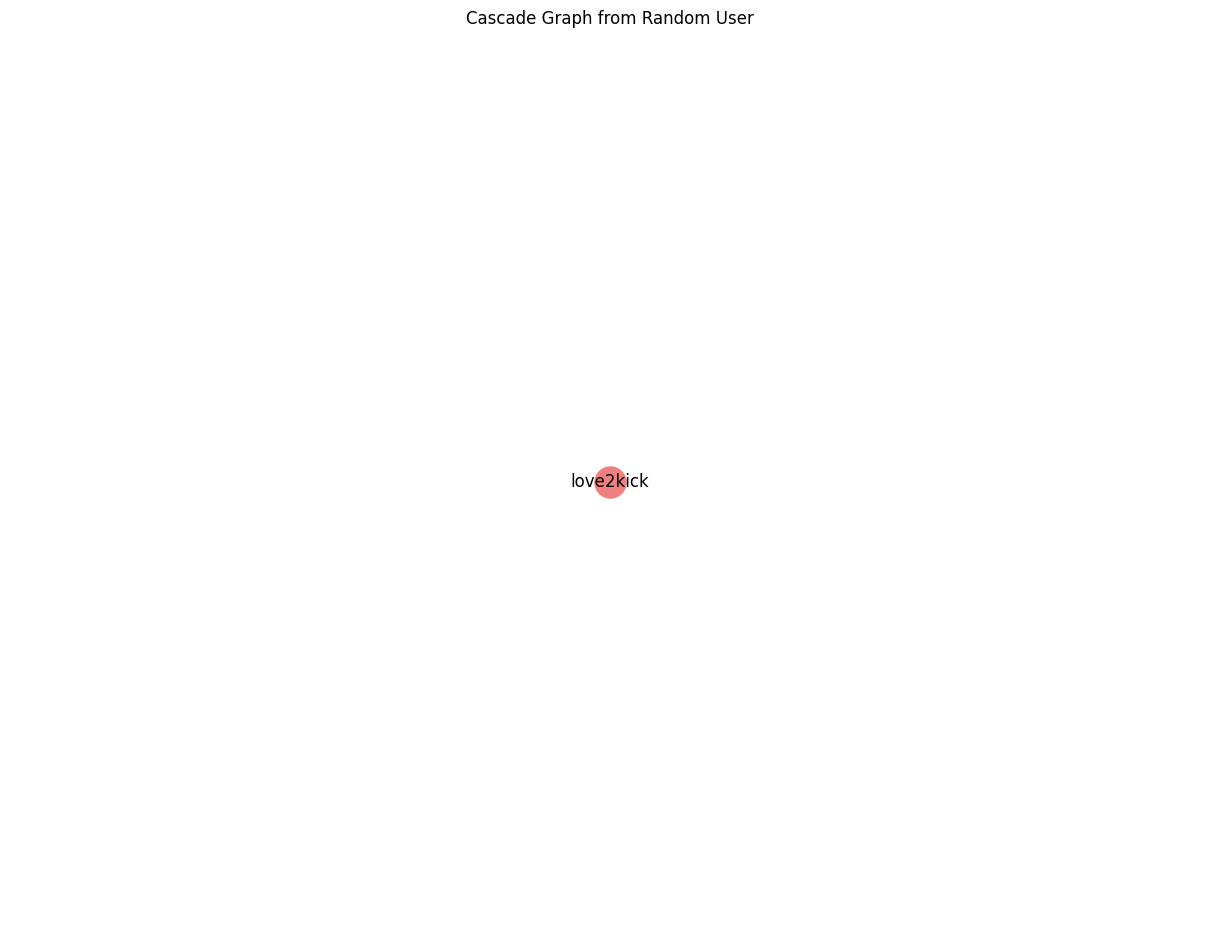

In [43]:
#random_user
steps, cascade_g_random = run_independent_cascade(G_full, random_node, p=0.44, max_steps=10)
if isinstance(cascade_g_random, nx.Graph) and cascade_g_random.number_of_nodes() > 0:
    plt.figure(figsize=(12, 9))
    pos = nx.spring_layout(cascade_g_random, seed=42)
    nx.draw(cascade_g_random, pos, with_labels=True, node_size=500, node_color='lightcoral', edge_color='gray', arrows=True)
    plt.title("Cascade Graph from Random User")
    plt.tight_layout()
    plt.savefig("cascade_graph_random.png")
    plt.show()
else:
    print("⚠️ Cascade graph is empty — no further spread from Random seed.")
